## CellPhoneDB Interaction

In [2]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import seaborn as sns
import logging
import os

import importlib
import warnings
warnings.filterwarnings("ignore")

import pickle as pkl
from matplotlib.colors import LinearSegmentedColormap
os.chdir(r'E:\AAA_Labwork\Tcell tissues\v2')

In [3]:
from IPython.display import HTML, display
from cellphonedb.utils import db_releases_utils

display(HTML(db_releases_utils.get_remote_database_versions_html()['db_releases_html_table']))

In [4]:
# -- Version of the databse
cpdb_version = 'v4.1.0'

# -- Path where the input files to generate the database are located
cpdb_target_dir = os.path.join('cpdb_tutorial/db/', cpdb_version)

In [5]:
from cellphonedb.utils import db_utils

db_utils.download_database(cpdb_target_dir, cpdb_version)

Downloaded cellphonedb.zip into cpdb_tutorial/db/v4.1.0
Downloaded complex_input.csv into cpdb_tutorial/db/v4.1.0
Downloaded gene_input.csv into cpdb_tutorial/db/v4.1.0
Downloaded interaction_input.csv into cpdb_tutorial/db/v4.1.0
Downloaded protein_input.csv into cpdb_tutorial/db/v4.1.0
Downloaded uniprot_synonyms.tsv into cpdb_tutorial/db/v4.1.0\sources


In [6]:
adata = sc.read_h5ad(r"gut_annotated.h5ad")

In [7]:
adata.obs['celltype_lowres'] = adata.obs['celltype_lowres'].astype('category')
ordered_celltype=['T Cells','NK','ILC','B Cells', 'Plasma Cells',
                  'Monocytes','Macrophages','Dendritic Cells', 
                  'Endothelial Cells', 'Telocytes','Fibroblastic Reticular Cells','Fibroblast','Smooth Muscle Cells',
                  'Intestinal Epithelial Cells','Enteric Glial Cells']
adata.obs['celltype_lowres'] = adata.obs['celltype_lowres'].cat.reorder_categories(ordered_celltype)

In [8]:
adata3 = adata[adata.obs['batch']=='3']
adata4 = adata[adata.obs['batch']=='4']
adata34 = adata[adata.obs['batch'].isin(['3','4'])]

### d3 cpdb

In [9]:
meta = pd.DataFrame(index=adata3.obs_names)
meta['cell_type'] = adata3.obs['celltype_lowres']
meta.to_csv('gut_3_meta.tsv', sep='\t')

In [10]:
set(meta['cell_type'])

{'B Cells',
 'Dendritic Cells',
 'Endothelial Cells',
 'Enteric Glial Cells',
 'Fibroblast',
 'Fibroblastic Reticular Cells',
 'ILC',
 'Intestinal Epithelial Cells',
 'Macrophages',
 'Monocytes',
 'NK',
 'Plasma Cells',
 'Smooth Muscle Cells',
 'T Cells',
 'Telocytes'}

In [11]:
adata3.obs = pd.DataFrame(adata3.obs['celltype_lowres'])
del adata3.var
del adata3.uns
del adata3.obsm
del adata3.obsp
del adata3.layers

In [12]:
adata3.write_h5ad('adata_gut_3_cpdb.h5ad')

In [13]:
cpdb_file_path = 'cpdb_tutorial/db/v4.1.0/cellphonedb.zip'
meta_file_path = 'gut_3_meta.tsv'
counts_file_path = 'adata_gut_3_cpdb.h5ad'
out_path = 'results/gut_3'

In [14]:
from cellphonedb.src.core.methods import cpdb_statistical_analysis_method

deconvoluted, means, pvalues, significant_means = cpdb_statistical_analysis_method.call(
    cpdb_file_path = cpdb_file_path,                 # mandatory: CellPhoneDB database zip file.
    meta_file_path = meta_file_path,                 # mandatory: tsv file defining barcodes to cell label.
    counts_file_path = counts_file_path,             # mandatory: normalized count matrix.
    counts_data = 'hgnc_symbol',                     # defines the gene annotation in counts matrix.       # optional (default: None): defines cells per microenvironment.
    iterations = 1000,                               # denotes the number of shufflings performed in the analysis.
    threshold = 0.3,                                 # defines the min % of cells expressing a gene for this to be employed in the analysis.
    threads = 6,                                     # number of threads to use in the analysis.
    debug_seed = 42,                                 # debug randome seed. To disable >=0.
    result_precision = 3,                            # Sets the rounding for the mean values in significan_means.
    pvalue = 0.05,                                   # P-value threshold to employ for significance.
    subsampling = False,                             # To enable subsampling the data (geometri sketching).
    subsampling_log = False,                         # (mandatory) enable subsampling log1p for non log-transformed data inputs.
    subsampling_num_pc = 100,                        # Number of componets to subsample via geometric skectching (dafault: 100).
    subsampling_num_cells = 1000,                    # Number of cells to subsample (integer) (default: 1/3 of the dataset).
    separator = '|',                                 # Sets the string to employ to separate cells in the results dataframes "cellA|CellB".
    debug = False,                                   # Saves all intermediate tables employed during the analysis in pkl format.
    output_path = out_path,                          # Path to save results.
    output_suffix = '_gut_3'                             # Replaces the timestamp in the output files by a user defined string in the  (default: None).
    )

Reading user files...
The following user files were loaded successfully:
adata_gut_3_cpdb.h5ad
gut_3_meta.tsv
[ ][CORE][18/03/25-20:00:18][INFO] [Cluster Statistical Analysis] Threshold:0.3 Iterations:1000 Debug-seed:42 Threads:6 Precision:3
[ ][CORE][18/03/25-20:00:18][WARNING] Debug random seed enabled. Set to 42
[ ][CORE][18/03/25-20:00:20][INFO] Running Real Analysis
[ ][CORE][18/03/25-20:00:20][INFO] Running Statistical Analysis


100%|██████████| 1000/1000 [00:43<00:00, 23.12it/s]

[ ][CORE][18/03/25-20:01:03][INFO] Building Pvalues result


[ ][CORE][18/03/25-20:01:04][INFO] Building results
Saved deconvoluted to results/gut_3\statistical_analysis_deconvoluted__gut_3.txt
Saved means to results/gut_3\statistical_analysis_means__gut_3.txt
Saved pvalues to results/gut_3\statistical_analysis_pvalues__gut_3.txt
Saved significant_means to results/gut_3\statistical_analysis_significant_means__gut_3.txt


In [15]:
interact = significant_means.iloc[:,12:]

In [16]:
interaction_names =  [ f"{a}|{b}" for a in list(set(adata3.obs['celltype_lowres'])) for b in list(set(adata3.obs['celltype_lowres'])) if a !=b]

In [17]:
interaction_names

['Enteric Glial Cells|B Cells',
 'Enteric Glial Cells|Endothelial Cells',
 'Enteric Glial Cells|ILC',
 'Enteric Glial Cells|Plasma Cells',
 'Enteric Glial Cells|Macrophages',
 'Enteric Glial Cells|Smooth Muscle Cells',
 'Enteric Glial Cells|Dendritic Cells',
 'Enteric Glial Cells|Monocytes',
 'Enteric Glial Cells|NK',
 'Enteric Glial Cells|Fibroblast',
 'Enteric Glial Cells|Intestinal Epithelial Cells',
 'Enteric Glial Cells|Telocytes',
 'Enteric Glial Cells|T Cells',
 'Enteric Glial Cells|Fibroblastic Reticular Cells',
 'B Cells|Enteric Glial Cells',
 'B Cells|Endothelial Cells',
 'B Cells|ILC',
 'B Cells|Plasma Cells',
 'B Cells|Macrophages',
 'B Cells|Smooth Muscle Cells',
 'B Cells|Dendritic Cells',
 'B Cells|Monocytes',
 'B Cells|NK',
 'B Cells|Fibroblast',
 'B Cells|Intestinal Epithelial Cells',
 'B Cells|Telocytes',
 'B Cells|T Cells',
 'B Cells|Fibroblastic Reticular Cells',
 'Endothelial Cells|Enteric Glial Cells',
 'Endothelial Cells|B Cells',
 'Endothelial Cells|ILC',
 'Endo

In [18]:
interactions = interact.loc[:,[ i for i in interact.columns if i in interaction_names ]].dropna(how='all').fillna(0)
interactions.index = significant_means.loc[interactions.index,'interacting_pair']
interactions = interactions.loc[interactions.sum(axis = 1).sort_values(ascending=False).index.tolist(),:]
interactions = interactions.loc[:,interactions.sum(axis = 0).sort_values(ascending=False).index.tolist()]
interactions = np.log(interactions+1)

In [19]:
adata

AnnData object with n_obs × n_vars = 14218 × 29051
    obs: 'n_counts', 'log_counts', 'n_genes', 'log10GenesPerUMI', 'mt_frac', 'ribo_frac', 'batch', 'S_score', 'G2M_score', 'S_G2M_diff', 'phase', 'leiden', 'leiden2', 'leiden3', 'cluster_lowres', 'celltype_lowres', 'celltype_highres', 'Donor ID'
    var: 'highly_variable'
    uns: 'batch_colors', 'celltype_highres_colors', 'celltype_lowres_colors', 'leiden', 'leiden2_colors', 'leiden3_colors', 'leiden_colors', 'leiden_sizes', 'neighbors', 'paga', 'pca', 'rank', 'rank2', 'rankendo', 'ranksmooth', 'residuals', 'scaled', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts', 'logcounts', 'raw'
    obsp: 'connectivities', 'distances'

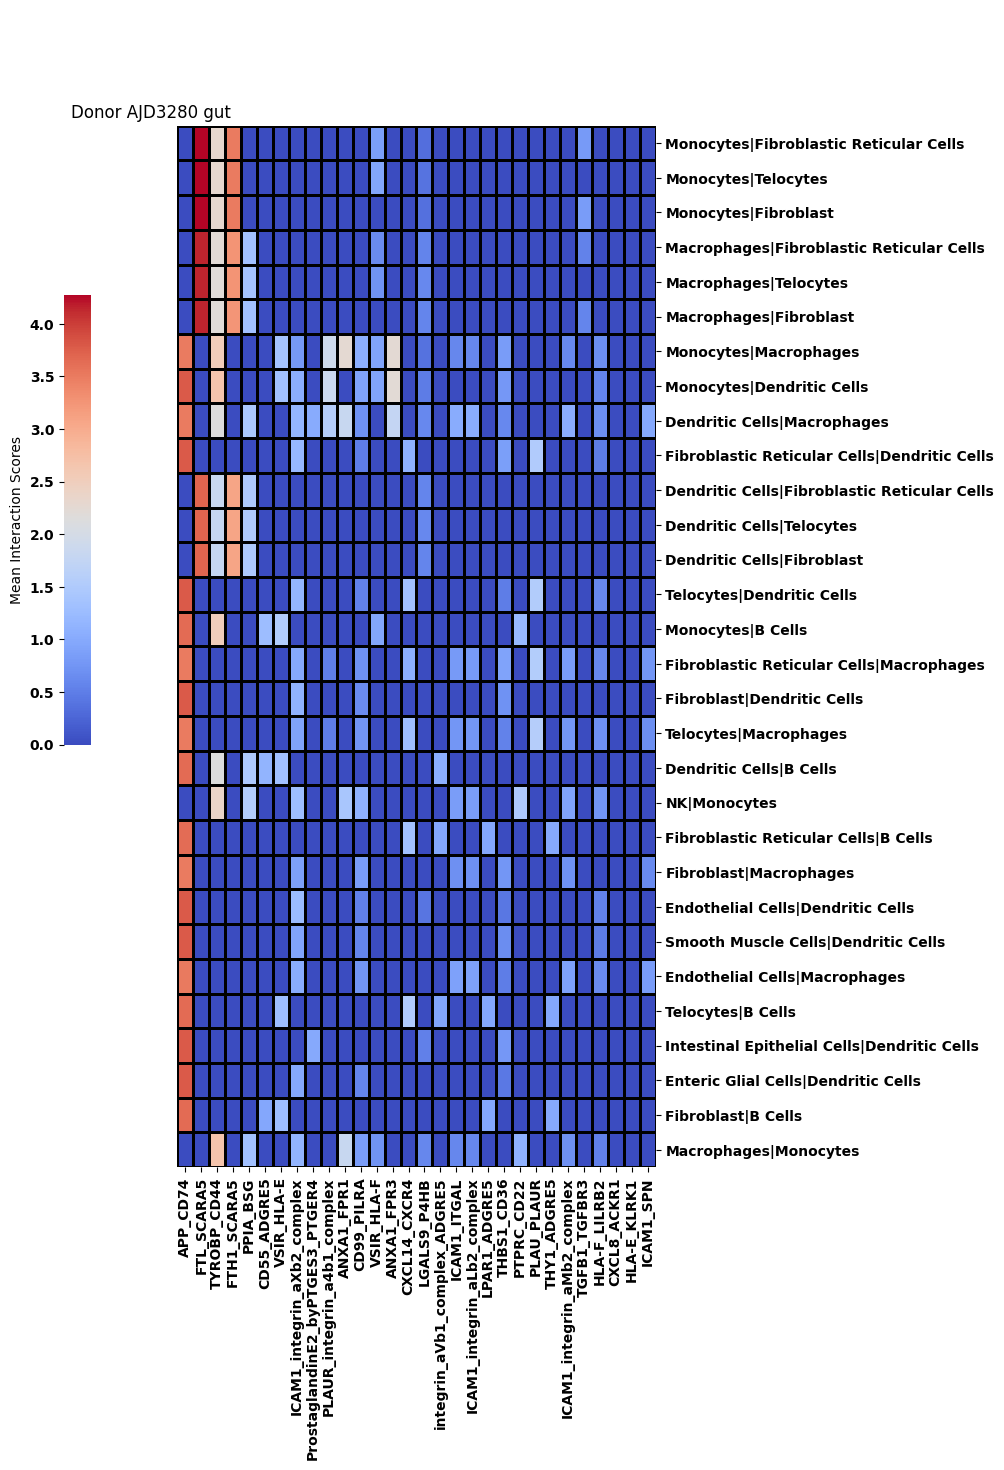

In [21]:
plt.rcParams.update({'font.size': 10, 'font.weight': 'heavy','axes.linewidth':0.5})
#plt.rcParams.update(plt.rcParamsDefault)
kwargs = {'cmap': 'coolwarm'}
clustergrid = sns.clustermap(interactions.T.iloc[0:30,0:30],figsize = (9,15),linewidths=1,
               linecolor = 'k',dendrogram_ratio = 0.1, colors_ratio = 0.5, 
               row_cluster = False,col_cluster=False,cbar_kws={'label': 'Mean Interaction Scores','location':"left"},
               **kwargs)
for a in clustergrid.ax_col_dendrogram.collections:
        a.set_linewidth(2)
clustergrid.ax_cbar.set_position([-0.05, 0.5, 0.03, 0.3])

axs = clustergrid.fig.get_axes()
for j in range(0,len(axs)): 
    axs[j].set_xlabel('')
axs[0].set_title(adata.obs['Donor ID'].values.categories[0] + ' gut')

plt.savefig('vis/cpdb_gut_3_3030_interact.png',dpi = 300,bbox_inches='tight')

In [22]:
interactions.to_csv('gut_3_cpdb_interactions.csv')

#### drawing chord

In [78]:
interact_counts = pd.DataFrame(index=list(adata.obs['celltype_lowres'].values.categories), columns=list(adata.obs['celltype_lowres'].values.categories))

In [79]:
interact_counts_melt = pd.DataFrame(index = range(int(len(interactions.columns)/2)), columns=['celltypeA','celltypeB','AB','BA'])

In [80]:
interaction_names_undirect = []
celltypes = list(set(adata3.obs['celltype_lowres']))
for a in range(len(celltypes)):
    for b in range(a+1,len(celltypes)):
        interaction_names_undirect.append(f"{celltypes[a]}|{celltypes[b]}")

In [81]:
# top 80% interaction
interactions_vis = interactions[interactions>np.percentile(interactions.values.flatten()[interactions.values.flatten()>0],5)]
# interactions_vis = interactions

In [85]:
for i in interactions_vis.columns:
    celltypeA = i.split('|')[0]
    celltypeB = i.split('|')[1]
    interact_counts.loc[celltypeA, celltypeB] = (interactions_vis[i]>0).sum()
    # interact_counts.loc[celltypeA, celltypeB] = interactions_vis[i].sum()
interact_counts=interact_counts.fillna(0)

In [88]:
interact_counts_undirect = interact_counts + interact_counts.T
interact_counts_undirect

,T Cells,NK,ILC,B Cells,Plasma Cells,Monocytes,Macrophages,Dendritic Cells,Endothelial Cells,Telocytes,Fibroblastic Reticular Cells,Fibroblast,Smooth Muscle Cells,Intestinal Epithelial Cells,Enteric Glial Cells
T Cells,0.0,22.0,10.0,13.0,1.0,20.0,22.0,19.0,13.0,13.0,14.0,11.0,3.0,3.0,4.0
NK,22.0,0.0,19.0,20.0,6.0,40.0,39.0,31.0,29.0,22.0,24.0,20.0,12.0,6.0,12.0
ILC,10.0,19.0,0.0,9.0,1.0,13.0,15.0,11.0,8.0,8.0,11.0,9.0,1.0,3.0,5.0
B Cells,13.0,20.0,9.0,0.0,2.0,19.0,24.0,15.0,6.0,13.0,13.0,11.0,4.0,3.0,4.0
Plasma Cells,1.0,6.0,1.0,2.0,0.0,4.0,6.0,3.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
Monocytes,20.0,40.0,13.0,19.0,4.0,0.0,46.0,34.0,26.0,23.0,25.0,24.0,11.0,8.0,7.0
Macrophages,22.0,39.0,15.0,24.0,6.0,46.0,0.0,33.0,28.0,33.0,36.0,32.0,17.0,11.0,16.0
Dendritic Cells,19.0,31.0,11.0,15.0,3.0,34.0,33.0,0.0,18.0,25.0,32.0,25.0,17.0,11.0,12.0
Endothelial Cells,13.0,29.0,8.0,6.0,1.0,26.0,28.0,18.0,0.0,31.0,23.0,19.0,23.0,15.0,4.0
Telocytes,13.0,22.0,8.0,13.0,0.0,23.0,33.0,25.0,31.0,0.0,28.0,26.0,16.0,5.0,16.0


In [61]:
for i,id in enumerate(interaction_names_undirect):
    celltypeA = id.split('|')[0]
    celltypeB = id.split('|')[1]
    interact_counts_melt['celltypeA'][i] = celltypeA
    interact_counts_melt['celltypeB'][i] = celltypeB
    interact_counts_melt['AB'][i] = (interactions_vis[id]>0).sum()
    interact_counts_melt['BA'][i] = (interactions_vis[celltypeB+'|'+celltypeA]>0).sum()

In [62]:
interact_counts_melt

,celltypeA,celltypeB,AB,BA
0,Enteric Glial Cells,B Cells,3,1
1,Enteric Glial Cells,Endothelial Cells,4,0
2,Enteric Glial Cells,ILC,5,0
3,Enteric Glial Cells,Plasma Cells,0,0
4,Enteric Glial Cells,Macrophages,12,4
...,...,...,...,...
100,Intestinal Epithelial Cells,T Cells,2,1
101,Intestinal Epithelial Cells,Fibroblastic Reticular Cells,2,4
102,Telocytes,T Cells,6,7
103,Telocytes,Fibroblastic Reticular Cells,8,20


In [89]:
# from chord import Chord
# Chord(interact_counts.values.tolist(), list(interact_counts.columns)).to_html("../../static/interactiveCharts/chord-diagram-chord-library.html")
interact_counts_undirect.to_csv('gut_3_cpdb_chord.csv')

In [63]:
# interact_counts['celltypeA'] =  interact_counts.index
# pd.melt(interact_counts, id_vars='celltypeA',value_vars= interact_counts.columns[0:-1],var_name='celltypeB',value_name='interaction_numbers').to_csv('gut_3_cpdb_chord_melt.csv')
interact_counts_melt.to_csv('gut_3_cpdb_chord_melt.csv')

In [65]:
interact_counts_melt[interact_counts_melt['celltypeA']=='Macrophages']

,celltypeA,celltypeB,AB,BA
60,Macrophages,Smooth Muscle Cells,5,12
61,Macrophages,Dendritic Cells,11,22
62,Macrophages,Monocytes,20,26
63,Macrophages,NK,19,20
64,Macrophages,Fibroblast,7,25
65,Macrophages,Intestinal Epithelial Cells,4,7
66,Macrophages,Telocytes,7,26
67,Macrophages,T Cells,10,12
68,Macrophages,Fibroblastic Reticular Cells,8,28


In [28]:
# for R chord we need to copy this for the palette!
gut_palette = ['#0351A8','#8CB0E0','#D56D11','#FFBB78','#234E08',
              '#53CB8B','#D30083','#CB788D','#4E195A','#C58CCF',
              '#AA290F','#B03FD1','#E8BCCF','#64605F','#B2AD9A']
for i in range(len(gut_palette)):
    print("'" + ordered_celltype[i] + "' = '" + gut_palette[i] + "',")

'T Cells' = '#0351A8',
'NK' = '#8CB0E0',
'ILC' = '#D56D11',
'B Cells' = '#FFBB78',
'Plasma Cells' = '#234E08',
'Monocytes' = '#53CB8B',
'Macrophages' = '#D30083',
'Dendritic Cells' = '#CB788D',
'Endothelial Cells' = '#4E195A',
'Telocytes' = '#C58CCF',
'Fibroblastic Reticular Cells' = '#AA290F',
'Fibroblast' = '#B03FD1',
'Smooth Muscle Cells' = '#E8BCCF',
'Intestinal Epithelial Cells' = '#64605F',
'Enteric Glial Cells' = '#B2AD9A',


### d4 cpdb

In [98]:
meta = pd.DataFrame(index=adata4.obs_names)
meta['cell_type'] = adata4.obs['celltype_lowres']
meta.to_csv('gut_4_meta.tsv', sep='\t')

In [99]:
set(meta['cell_type'])

{'B Cells',
 'Dendritic Cells',
 'Endothelial Cells',
 'Enteric Glial Cells',
 'Fibroblast',
 'Fibroblastic Reticular Cells',
 'ILC',
 'Intestinal Epithelial Cells',
 'Macrophages',
 'Monocytes',
 'NK',
 'Plasma Cells',
 'Smooth Muscle Cells',
 'T Cells',
 'Telocytes'}

In [100]:
adata4.obs = pd.DataFrame(adata4.obs['celltype_lowres'])
del adata4.var
del adata4.uns
del adata4.obsm
del adata4.obsp
del adata4.layers

In [101]:
adata4.write_h5ad('adata_gut_4_cpdb.h5ad')

In [102]:
cpdb_file_path = 'cpdb_tutorial/db/v4.1.0/cellphonedb.zip'
meta_file_path = 'gut_4_meta.tsv'
counts_file_path = 'adata_gut_4_cpdb.h5ad'
out_path = 'results/gut_4'

In [103]:
from cellphonedb.src.core.methods import cpdb_statistical_analysis_method

deconvoluted, means, pvalues, significant_means = cpdb_statistical_analysis_method.call(
    cpdb_file_path = cpdb_file_path,                 # mandatory: CellPhoneDB database zip file.
    meta_file_path = meta_file_path,                 # mandatory: tsv file defining barcodes to cell label.
    counts_file_path = counts_file_path,             # mandatory: normalized count matrix.
    counts_data = 'hgnc_symbol',                     # defines the gene annotation in counts matrix.       # optional (default: None): defines cells per microenvironment.
    iterations = 1000,                               # denotes the number of shufflings performed in the analysis.
    threshold = 0.3,                                 # defines the min % of cells expressing a gene for this to be employed in the analysis.
    threads = 6,                                     # number of threads to use in the analysis.
    debug_seed = 42,                                 # debug randome seed. To disable >=0.
    result_precision = 3,                            # Sets the rounding for the mean values in significan_means.
    pvalue = 0.05,                                   # P-value threshold to employ for significance.
    subsampling = False,                             # To enable subsampling the data (geometri sketching).
    subsampling_log = False,                         # (mandatory) enable subsampling log1p for non log-transformed data inputs.
    subsampling_num_pc = 100,                        # Number of componets to subsample via geometric skectching (dafault: 100).
    subsampling_num_cells = 1000,                    # Number of cells to subsample (integer) (default: 1/3 of the dataset).
    separator = '|',                                 # Sets the string to employ to separate cells in the results dataframes "cellA|CellB".
    debug = False,                                   # Saves all intermediate tables employed during the analysis in pkl format.
    output_path = out_path,                          # Path to save results.
    output_suffix = '_gut_4'                             # Replaces the timestamp in the output files by a user defined string in the  (default: None).
    )

Reading user files...
The following user files were loaded successfully:
adata_gut_4_cpdb.h5ad
gut_4_meta.tsv
[ ][CORE][19/03/25-09:49:27][INFO] [Cluster Statistical Analysis] Threshold:0.3 Iterations:1000 Debug-seed:42 Threads:6 Precision:3
[ ][CORE][19/03/25-09:49:27][WARNING] Debug random seed enabled. Set to 42
[ ][CORE][19/03/25-09:49:28][INFO] Running Real Analysis
[ ][CORE][19/03/25-09:49:28][INFO] Running Statistical Analysis


100%|██████████| 1000/1000 [00:54<00:00, 18.51it/s]

[ ][CORE][19/03/25-09:50:22][INFO] Building Pvalues result


[ ][CORE][19/03/25-09:50:22][INFO] Building results
Saved deconvoluted to results/gut_4\statistical_analysis_deconvoluted__gut_4.txt
Saved means to results/gut_4\statistical_analysis_means__gut_4.txt
Saved pvalues to results/gut_4\statistical_analysis_pvalues__gut_4.txt
Saved significant_means to results/gut_4\statistical_analysis_significant_means__gut_4.txt


In [104]:
interact = significant_means.iloc[:,12:]

In [105]:
interaction_names =  [ f"{a}|{b}" for a in list(set(adata4.obs['celltype_lowres'])) for b in list(set(adata4.obs['celltype_lowres'])) if a !=b]

In [106]:
interaction_names

['Enteric Glial Cells|B Cells',
 'Enteric Glial Cells|Endothelial Cells',
 'Enteric Glial Cells|ILC',
 'Enteric Glial Cells|Macrophages',
 'Enteric Glial Cells|Smooth Muscle Cells',
 'Enteric Glial Cells|Dendritic Cells',
 'Enteric Glial Cells|Monocytes',
 'Enteric Glial Cells|Intestinal Epithelial Cells',
 'Enteric Glial Cells|Fibroblast',
 'Enteric Glial Cells|Telocytes',
 'Enteric Glial Cells|Plasma Cells',
 'Enteric Glial Cells|NK',
 'Enteric Glial Cells|T Cells',
 'Enteric Glial Cells|Fibroblastic Reticular Cells',
 'B Cells|Enteric Glial Cells',
 'B Cells|Endothelial Cells',
 'B Cells|ILC',
 'B Cells|Macrophages',
 'B Cells|Smooth Muscle Cells',
 'B Cells|Dendritic Cells',
 'B Cells|Monocytes',
 'B Cells|Intestinal Epithelial Cells',
 'B Cells|Fibroblast',
 'B Cells|Telocytes',
 'B Cells|Plasma Cells',
 'B Cells|NK',
 'B Cells|T Cells',
 'B Cells|Fibroblastic Reticular Cells',
 'Endothelial Cells|Enteric Glial Cells',
 'Endothelial Cells|B Cells',
 'Endothelial Cells|ILC',
 'Endo

In [107]:
interactions = interact.loc[:,[ i for i in interact.columns if i in interaction_names ]].dropna(how='all').fillna(0)
interactions.index = significant_means.loc[interactions.index,'interacting_pair']
interactions = interactions.loc[interactions.sum(axis = 1).sort_values(ascending=False).index.tolist(),:]
interactions = interactions.loc[:,interactions.sum(axis = 0).sort_values(ascending=False).index.tolist()]
interactions = np.log(interactions+1)

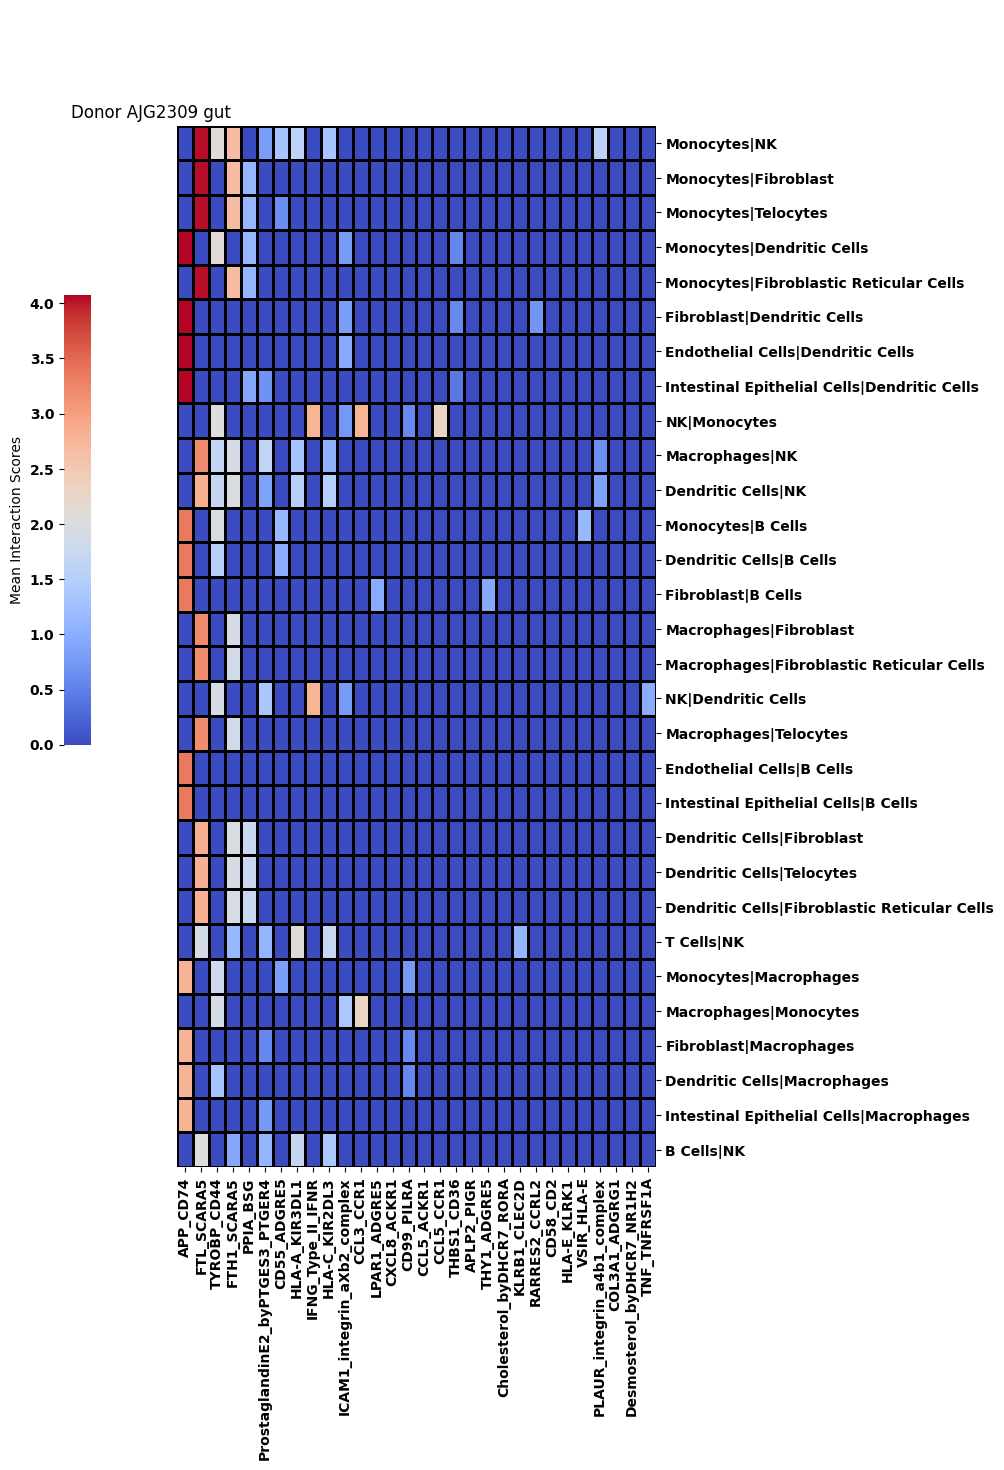

In [108]:

plt.rcParams.update({'font.size': 10, 'font.weight': 'heavy','axes.linewidth':0.5})
#plt.rcParams.update(plt.rcParamsDefault)
kwargs = {'cmap': 'coolwarm'}
clustergrid = sns.clustermap(interactions.T.iloc[0:30,0:30],figsize = (9,15),linewidths=1,
               linecolor = 'k',dendrogram_ratio = 0.1, colors_ratio = 0.5, 
               row_cluster = False,col_cluster=False,cbar_kws={'label': 'Mean Interaction Scores','location':"left"},
               **kwargs)
for a in clustergrid.ax_col_dendrogram.collections:
        a.set_linewidth(2)
clustergrid.ax_cbar.set_position([-0.05, 0.5, 0.03, 0.3])

axs = clustergrid.fig.get_axes()
for j in range(0,len(axs)): 
    axs[j].set_xlabel('')
axs[0].set_title(adata.obs['Donor ID'].values.categories[1] + ' gut')

plt.savefig('cpdb_gut_4_3030_interact.png',dpi = 300,bbox_inches='tight')

In [109]:
interactions.to_csv('gut_4_cpdb_interactions.csv')

#### drawing chord

In [92]:
interactions = pd.read_csv('gut_4_cpdb_interactions.csv',index_col= 0)

In [110]:
interact_counts = pd.DataFrame(index=list(adata.obs['celltype_lowres'].values.categories), columns=list(adata.obs['celltype_lowres'].values.categories))

In [ ]:
# top 80% interaction
interactions_vis = interactions[interactions>np.percentile(interactions.values.flatten()[interactions.values.flatten()>0],5)]
# interactions_vis = interactions

In [112]:
for i in interactions_vis.columns:
    celltypeA = i.split('|')[0]
    celltypeB = i.split('|')[1]
    interact_counts.loc[celltypeA, celltypeB] = (interactions_vis[i]>0).sum()
    # interact_counts.loc[celltypeA, celltypeB] = interactions_vis[i].sum()
interact_counts=interact_counts.fillna(0)

In [113]:
interact_counts_undirect = interact_counts + interact_counts.T
interact_counts_undirect

,T Cells,NK,ILC,B Cells,Plasma Cells,Monocytes,Macrophages,Dendritic Cells,Endothelial Cells,Telocytes,Fibroblastic Reticular Cells,Fibroblast,Smooth Muscle Cells,Intestinal Epithelial Cells,Enteric Glial Cells
T Cells,0,14,6,5,2,11,5,9,6,4,7,8,2,4,4
NK,14,0,9,8,5,21,11,19,14,6,11,13,8,7,6
ILC,6,9,0,3,2,8,5,8,4,2,4,5,1,1,3
B Cells,5,8,3,0,3,9,4,7,2,4,6,7,1,3,2
Plasma Cells,2,5,2,3,0,4,2,4,2,1,1,1,1,0,0
Monocytes,11,21,8,9,4,0,9,13,15,11,10,17,7,10,8
Macrophages,5,11,5,4,2,9,0,7,7,7,6,10,2,5,4
Dendritic Cells,9,19,8,7,4,13,7,0,11,7,9,13,6,11,6
Endothelial Cells,6,14,4,2,2,15,7,11,0,24,21,26,16,11,10
Telocytes,4,6,2,4,1,11,7,7,24,0,7,10,5,3,3


In [114]:
# from chord import Chord
# Chord(interact_counts.values.tolist(), list(interact_counts.columns)).to_html("../../static/interactiveCharts/chord-diagram-chord-library.html")
interact_counts_undirect.to_csv('gut_4_cpdb_chord.csv')

In [ ]:
# for R chord we need to copy this for the palette!
gut_palette = ['#0351A8','#8CB0E0','#D56D11','#FFBB78','#234E08',
              '#53CB8B','#D30083','#CB788D','#4E195A','#C58CCF',
              '#AA290F','#B03FD1','#E8BCCF','#64605F','#B2AD9A']
for i in range(len(gut_palette)):
    print("'" + ordered_celltype[i] + "' = '" + gut_palette[i] + "',")

'T Cells' = '#0351A8',
'NK' = '#8CB0E0',
'ILC' = '#D56D11',
'B Cells' = '#FFBB78',
'Plasma Cells' = '#234E08',
'Monocytes' = '#53CB8B',
'Macrophages' = '#D30083',
'Dendritic Cells' = '#CB788D',
'Endothelial Cells' = '#4E195A',
'Mesenchymal Stromal Cells' = '#C58CCF',
'Fibroblastic Reticular Cells' = '#AA290F',
'Fibroblast' = '#B03FD1',
'Smooth Muscle Cells' = '#E8BCCF',
'Intestinal Epithelial Cells' = '#64605F',
'Neurons' = '#B2AD9A',
